# CharFFN: next character prediction using fixed-context window feedforward networks

In [1]:
import numpy as np
import pandas as pd
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.nn.functional as F

# Preprocess data

In [2]:
file_path = "../data/alpaca_data_cleaned.json"
context_length = 10

In [3]:
def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def preprocess_data(data):
    sequences = []
    for item in data:
        sequence = list(item['instruction']) + ['\n'] + list(item['input']) + ['\n'] + list(item['output']) + ['[EOS]']
        sequences.append(sequence)
    return sequences

valid_chars = list('abcdefghijklmnopqrstuvwxyz ?!.,\n')
def preprocess_data_simple(data):
    sequences = []
    for item in data:
        instruction_alpha = ''.join([char for char in item['instruction'].lower() if char in valid_chars])
        input_alpha = ''.join([char for char in item['input'].lower() if char in valid_chars])
        output_alpha = ''.join([char for char in item['output'].lower() if char in valid_chars])

        sequence = list(instruction_alpha) + ['\n'] + list(input_alpha) + ['\n'] + list(output_alpha) + ['[EOS]']
        sequences.append(sequence)
    return sequences

def create_vocab(sequences):
    chars = [char for seq in sequences for char in seq]
    return sorted(set(chars))

def one_hot_encode(sequence, char_to_idx):
    one_hot = np.zeros((len(sequence), len(char_to_idx)), dtype=np.int32)
    for i, char in enumerate(sequence):
        one_hot[i, char_to_idx[char]] = 1
    return one_hot

def numerical_encode(sequence, char_to_idx):
    numerical_encoding = np.zeros(len(sequence), dtype=np.int32)
    for i, char in enumerate(sequence):
        numerical_encoding[i] = char_to_idx[char]
    return numerical_encoding

def create_training_examples(sequences, char_to_idx, input_length=10):
    x = []
    y = []

    for seq in sequences:
        encoded_seq = one_hot_encode(seq, char_to_idx)
        numerical_encode_seq = numerical_encode(seq, char_to_idx)
        total_chars = len(seq)

        for i in range(total_chars - input_length):
            x.append(encoded_seq[i:i+input_length])
            y.append(encoded_seq[i+input_length])

    return np.array(x), np.array(y)

# Main script
data = read_json(file_path)
#sequences = preprocess_data(data)
sequences = preprocess_data_simple(data)

vocab = create_vocab(sequences)
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

X, Y = create_training_examples(sequences, char_to_idx, input_length=context_length)
X = X.reshape(X.shape[0], -1)

print(f"Number of training examples: {X.shape[0]}")
print(f"Example input shape: {X[0].shape}")
print(f"output shape: {Y.shape}")

Number of training examples: 38471521
Example input shape: (330,)
output shape: (38471521, 33)


In [4]:
idx_to_char

{0: '\n',
 1: ' ',
 2: '!',
 3: ',',
 4: '.',
 5: '?',
 6: '[EOS]',
 7: 'a',
 8: 'b',
 9: 'c',
 10: 'd',
 11: 'e',
 12: 'f',
 13: 'g',
 14: 'h',
 15: 'i',
 16: 'j',
 17: 'k',
 18: 'l',
 19: 'm',
 20: 'n',
 21: 'o',
 22: 'p',
 23: 'q',
 24: 'r',
 25: 's',
 26: 't',
 27: 'u',
 28: 'v',
 29: 'w',
 30: 'x',
 31: 'y',
 32: 'z'}

(array([3.945100e+05, 6.227787e+06, 4.750000e+03, 3.807990e+05,
        4.083120e+05, 1.256700e+04, 5.176000e+04, 2.590824e+06,
        4.096430e+05, 1.159261e+06, 1.129321e+06, 3.831490e+06,
        6.649500e+05, 6.935500e+05, 1.278740e+06, 2.360896e+06,
        4.016400e+04, 1.965220e+05, 1.266667e+06, 7.919590e+05,
        2.335505e+06, 2.292594e+06, 7.370610e+05, 4.028500e+04,
        1.957172e+06, 2.098974e+06, 2.790468e+06, 8.918070e+05,
        3.712270e+05, 4.328260e+05, 8.453700e+04, 5.445930e+05]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 <BarContainer object of 32 artists>)

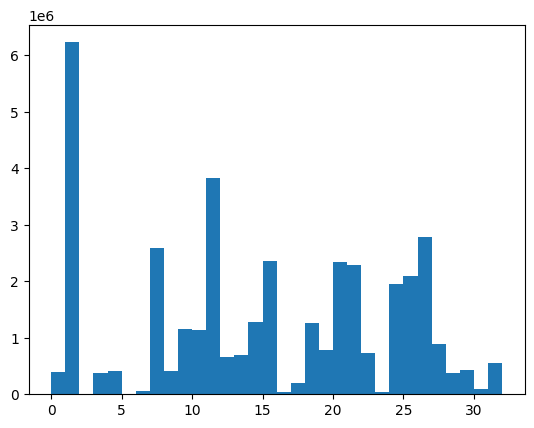

In [5]:
import matplotlib.pyplot as plt
plt.hist(np.argmax(Y, 1), bins=range(len(char_to_idx)))

In [6]:
X.shape, Y.shape

((38471521, 330), (38471521, 33))

In [7]:
# To limit size of large dataset
X = X[:1000000, :]
Y = Y[:1000000, :]
X.shape, Y.shape

((1000000, 330), (1000000, 33))

In [8]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class FixedContextWindowFeedforward(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(FixedContextWindowFeedforward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Assuming you have a dataset and DataLoader for training and testing
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float)  # Assuming Y_train contains class indices
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Define parameters
input_size = 330 # Set manually: 320 for small, 330 for medium/large
context_size = 10
hidden_size_1 = 8
hidden_size_2 = 128
output_size = 33 # Set manually: 32 for small, 33 for medium/large
batch_size = 8
num_epochs = 10

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
model = FixedContextWindowFeedforward(input_size, hidden_size_1, hidden_size_2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model over multiple epochs
start_time = time.time()  # Record the start time
for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    model.train()  # Set the model to training mode

    for batch_data, batch_labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_data)

        # Calculate loss
        loss = criterion(outputs, batch_labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        total_loss += loss.item()

        # Calculate accuracy
        predicted_chars = torch.argmax(outputs, dim=1)
        true_chars = torch.argmax(batch_labels, dim=1)

        total_samples += batch_labels.size(0)
        total_correct += (predicted_chars == true_chars).sum().item()

    # Print training loss and accuracy
    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {accuracy * 100:.2f}%')

# Get training time
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f'Training took {elapsed_time} seconds.')

# Save the trained model
torch.save(model.state_dict(), f'model/char_ffn_embed_{hidden_size_1}_epoch_{num_epochs}_datasetsize_{X.shape[0]}.pth')

Epoch 1/10: 100%|██████████| 100000/100000 [01:29<00:00, 1116.33it/s]


Epoch 1/10, Loss: 2.115755740480721, Accuracy: 37.00%


Epoch 2/10: 100%|██████████| 100000/100000 [00:57<00:00, 1729.55it/s]


Epoch 2/10, Loss: 1.9800605655241013, Accuracy: 40.88%


Epoch 3/10: 100%|██████████| 100000/100000 [01:24<00:00, 1177.94it/s]


Epoch 3/10, Loss: 1.9479101510062813, Accuracy: 41.94%


Epoch 4/10: 100%|██████████| 100000/100000 [00:56<00:00, 1767.98it/s]


Epoch 4/10, Loss: 1.9327405027657747, Accuracy: 42.42%


Epoch 5/10: 100%|██████████| 100000/100000 [01:10<00:00, 1417.16it/s]


Epoch 5/10, Loss: 1.9247196085721254, Accuracy: 42.61%


Epoch 6/10: 100%|██████████| 100000/100000 [01:59<00:00, 836.81it/s]


Epoch 6/10, Loss: 1.9193334785673022, Accuracy: 42.82%


Epoch 7/10: 100%|██████████| 100000/100000 [02:46<00:00, 601.03it/s]


Epoch 7/10, Loss: 1.9157472554713488, Accuracy: 42.93%


Epoch 8/10: 100%|██████████| 100000/100000 [01:27<00:00, 1140.13it/s]


Epoch 8/10, Loss: 1.913881583392024, Accuracy: 43.03%


Epoch 9/10: 100%|██████████| 100000/100000 [01:02<00:00, 1609.34it/s]


Epoch 9/10, Loss: 1.9129960120263696, Accuracy: 43.04%


Epoch 10/10: 100%|██████████| 100000/100000 [01:29<00:00, 1121.05it/s]

Epoch 10/10, Loss: 1.9129467388671637, Accuracy: 43.14%
Training took 884.440655708313 seconds.


In [10]:
# Load the model back
model = FixedContextWindowFeedforward(input_size, hidden_size_1, hidden_size_2, output_size)
model.load_state_dict(torch.load(f'model/char_ffn_embed_{hidden_size_1}_epoch_{num_epochs}_datasetsize_{X.shape[0]}.pth'))
model.eval()  # Set the model to evaluation mode

# Test the model
test_loss = 0.0
total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for test_data, test_labels in test_loader:
        # Calculate loss
        test_outputs = model(test_data)
        test_loss += criterion(test_outputs, test_labels).item()
        
        # Calculate accuracy
        predicted_chars = torch.argmax(test_outputs, dim=1)
        true_chars = torch.argmax(test_labels, dim=1)

        total_samples += test_labels.size(0)
        correct_predictions += (predicted_chars == true_chars).sum().item()
        
# Calculate accuracy
test_accuracy = correct_predictions / total_samples
average_test_loss = test_loss / len(test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 43.56%
